In [1]:
import datetime
import pandas as pd
import numpy as np

In [2]:
def roundTime(dt=None):    
    dt = dt.to_pydatetime()
    roundTo = 15*60    
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

def create_start_timestamp(row):
    return row['Start Date'][:10] + " " + row['Start Time']

def create_end_timestamp(row):
    return row['End Date'][:10] + " " + row['End Time']


def conv_entries(arr):  
    int_arr = [int(x) for x in arr]
    if int_arr[2] > 29:
        int_arr[1] += 1        
    int_arr[2] = 0
    mins = int_arr[0]*60 + int_arr[1]
    rem = mins % 15
    if rem > 7:
        mins += (15-rem)
    else:
        mins -= rem        
    return mins

def calc_quarter_load(row):
    dur = row['Charging Time (hh:mm:ss)']
    total = row['Energy (kWh)']
    return (total/dur)*15.0

def calc_sessions_dur(row):
    return (row['Total kWh']/50.0)*60.0

def calc_minute_load(row):
    return row['Total kWh']/row['Session_Duration']


def add_to_backbone(row):
    iters = int(row['Session_Duration'])
    load_per_min = 0.8333333333333334
    for i in range(iters):
        backbone.loc[backbone['date_time'] == row['Start_Timestamp'] + datetime.timedelta(minutes=i), 'value'] += load_per_min   
        backbone.loc[backbone['date_time'] == row['Start_Timestamp'] + datetime.timedelta(minutes=i), 'sessions'] += 1    
        
def fill_nan(row):
    flavors = ['APT 7kW Single Outlet','APT 22kW Dual Outlet','APT 50kW Raption','APT Dual Rapid Charger','APT Triple Rapid Charger',' APT 7kW Dual Outlet','APT 7kW Dual Outlet']
    test = row['Unnamed: 14']
    if test in flavors:
        row['Unnamed: 15'] = test

In [3]:
dfdundee = pd.read_csv (r'/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Dundee_all.csv')
exclude_stations = [51548,51547,51549,51550,50912,50914,50913,50262]
rapid_chargers = ["APT 50kW Raption", "APT Triple Rapid Charger", "APT Dual Rapid Charger"]
fast_chargers = ['APT 22kW Dual Outlet']
home_chargers = ['APT 7kW Single Outlet',' APT 7kW Dual Outlet','APT 7kW Dual Outlet']


for row in dfdundee.itertuples():
    if pd.isna(dfdundee.at[row.Index, 'Unnamed: 15']):
        dfdundee.loc[row.Index, 'Unnamed: 15'] = dfdundee.at[row.Index, 'Unnamed: 14']
        #print(dfdundee.loc[row.Index, 'Unnamed: 15'])
            
    
    

# dfdundee = dfdundee.apply(lambda row: fill_nan(row), axis=1)
list(dfdundee)
list(set(list(dfdundee['Unnamed: 15'])))


[nan,
 'APT 50kW Raption',
 'APT Dual Rapid Charger',
 'APT 7kW Dual Outlet',
 ' APT 7kW Dual Outlet',
 'APT 7kW Single Outlet',
 'APT Triple Rapid Charger',
 'APT 22kW Dual Outlet']

In [4]:
dfdundee = dfdundee[dfdundee['CP ID'].isin(exclude_stations) == False]
dfdundee = dfdundee[dfdundee['Unnamed: 15'].isin(rapid_chargers) == True]
dfdundee = dfdundee[dfdundee['Total kWh'].notna()]

In [5]:
dfdundee['Start_Timestamp'] = dfdundee.apply(lambda row: create_start_timestamp(row), axis=1)
dfdundee['End_Timestamp'] = dfdundee.apply(lambda row: create_end_timestamp(row), axis=1)

dfdundee['Session_Duration'] = dfdundee.apply(lambda row: calc_sessions_dur(row), axis=1)
dfdundee['Session_Duration'] = round(dfdundee['Session_Duration'])
dfdundee = dfdundee[dfdundee['Session_Duration'] > 0.0]
dfdundee['Minute_Load'] = dfdundee.apply(lambda row: calc_minute_load(row), axis=1)

In [6]:
cutoff = datetime.datetime.strptime("2017-02-11 00:00", '%Y-%m-%d %H:%M')
dfdundee['Start_Timestamp'] = dfdundee['Start_Timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))
dfdundee['End_Timestamp'] = dfdundee['End_Timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))
dfdundee = dfdundee[dfdundee['Start_Timestamp'] >= cutoff]

In [7]:
start = dfdundee['Start_Timestamp'].min()
print(start)
start = cutoff
end = dfdundee['End_Timestamp'].max()
print(end)
backbone = pd.DataFrame({'date_time': pd.date_range(start, end, freq="1min")})
backbone.set_index('date_time')
backbone['value'] = 0.0
backbone['sessions'] = 0

2017-02-11 00:04:00
2018-12-05 23:27:00


In [8]:
end

Timestamp('2018-12-05 23:27:00')

In [9]:
from scipy import stats
dfdundee['z_score'] = np.abs(stats.zscore(dfdundee['Session_Duration']))
dfdundee = dfdundee[dfdundee.z_score <= 3.0]


In [10]:
dfdundee.apply(lambda row: add_to_backbone(row), axis=1)

4        None
8        None
11       None
12       None
19       None
         ... 
33197    None
33198    None
33199    None
33200    None
33201    None
Length: 13603, dtype: object

In [11]:
max(backbone['value'])
min(backbone['sessions'])

0

In [12]:
backbone_quarter = pd.DataFrame({'date_time': pd.date_range(start, end, freq="15min")})
backbone_quarter['value'] = 0.0
backbone_quarter['sessions'] = 0
backbone_quarter = backbone_quarter[:-1]

In [13]:
quarter_loads = []
quarter_sessions = []
values = backbone['value']
sessions = backbone['sessions']
avg = 0.0
sss = 0
for i in range(len(values)):
    avg += values[i]
    sss += sessions[i]
    if (i+1)%15 == 0:
        quarter_loads.append(avg/15.0)
        quarter_sessions.append(sss)        
        avg = 0.0
        sss = 0
    
print(len(quarter_loads))
len(backbone)

63645


954688

In [14]:
backbone_quarter['value'] = quarter_loads
backbone_quarter['sessions'] = quarter_sessions
max(backbone_quarter['sessions'])


backbone_daily = pd.DataFrame({'date_time': pd.date_range(start, end, freq="24h")})
backbone_daily.set_index('date_time')
backbone_daily['value'] = 0.0
backbone_daily['sessions'] = 0
backbone_daily = backbone_daily[:-1]

for row in backbone_daily.itertuples():
    avg_load = 0.0
    avg_sessions = 0
    start_time = backbone_daily.at[row.Index, 'date_time']
    for i in range(96):
        avg_load += backbone_quarter[backbone_quarter['date_time'] == start_time + datetime.timedelta(minutes=15*i)]['value'].item()    
        avg_sessions += backbone_quarter[backbone_quarter['date_time'] == start_time + datetime.timedelta(minutes=15*i)]['sessions'].item()
    avg_load /= 96.0    
    backbone_daily.loc[row.Index, 'value'] = avg_load  
    backbone_daily.loc[row.Index, 'sessions'] = avg_sessions  


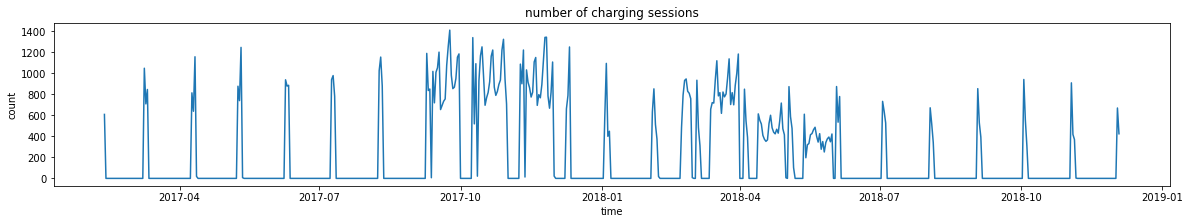

In [15]:
import matplotlib.pyplot as plt

backbone_daily['sessions']

x_sessions = backbone_daily['date_time']
y_sessions = backbone_daily['sessions']
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(x_sessions, y_sessions)
plt.xlabel("time")
plt.ylabel("count")
plt.title("number of charging sessions")
plt.show()

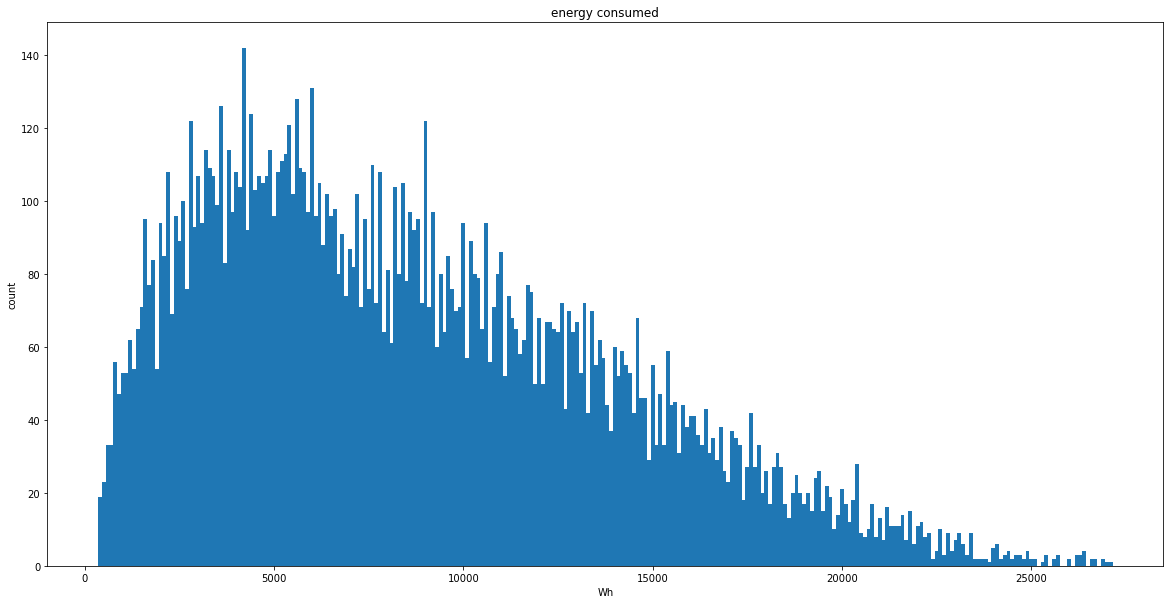

In [16]:


dfdundee['Energy__Wh_'] = dfdundee['Total kWh'].apply(lambda x: round(int(x*1000)/100)*100)
vc_energy = dfdundee.Energy__Wh_.value_counts()
vc_energy = vc_energy.sort_index()

x_energy = vc_energy.index
y_energy = vc_energy.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_energy, y_energy, width=100)
plt.xlabel("Wh")
plt.ylabel("count")
plt.title("energy consumed")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/dundee_energy.png')
plt.show()

In [17]:
# dfdundee['Start Time']

# vc_plugin = dfdundee['Start Time'].value_counts()
# vc_plugin = vc_plugin.sort_index()

# x_plugin = []
# for time in vc_plugin.index:
#     minutes = int(time[:2])*60 + int(time[3:])
#     x_plugin.append(minutes)
# len(x_plugin)

# #x_plugin = vc_plugin.index
# #x_plugin = range(94)
# y_plugin = vc_plugin.values
# plt.rcParams["figure.figsize"] = (20,10)
# plt.bar(x_plugin, y_plugin, width=1)
# plt.xlabel("timeslot")
# plt.ylabel("count")
# plt.title("plugin time")
# plt.show()


In [23]:
dfdundee.Start_Timestamp = dfdundee.Start_Timestamp.map(roundTime)


def get_hs_and_mins(ts):
    hours = str(ts.hour)
    minutes = str(ts.minute)
    if hours == '0':
        hours = '00'
    if minutes == '0':
        minutes = '00'        
    ts = datetime.datetime.strptime(hours + ":" + minutes, '%H:%M')    
    return ts

dfdundee['plugin_time'] = dfdundee.Start_Timestamp.map(get_hs_and_mins)
vc_plugin = dfdundee.plugin_time.value_counts()
vc_plugin = vc_plugin.sort_index()

len(vc_plugin.index)





96

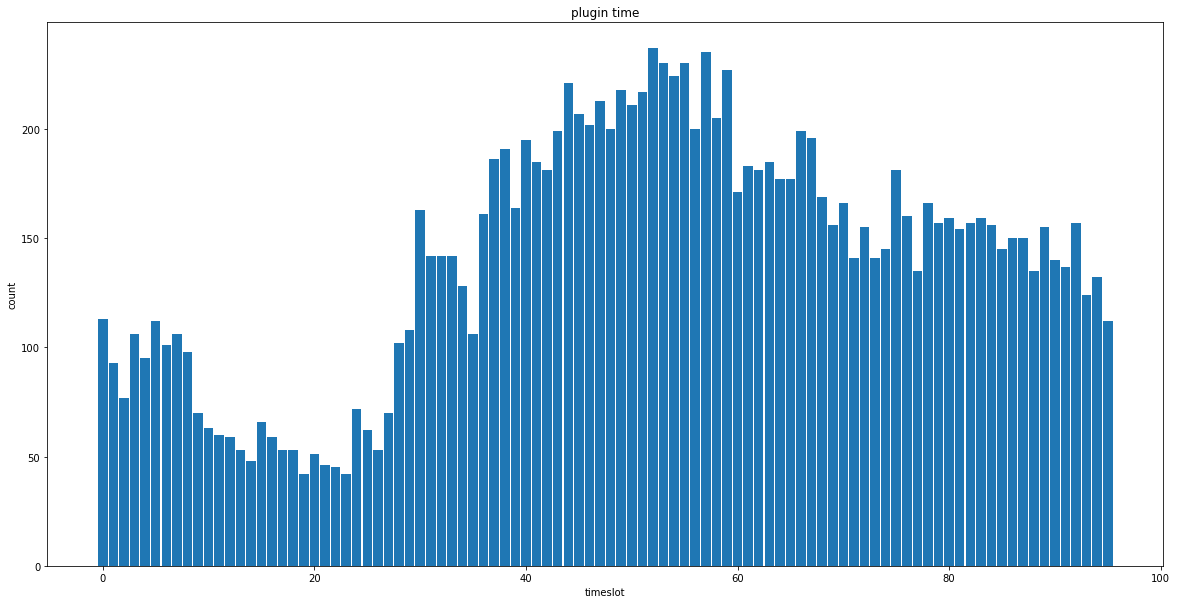

In [24]:
x_plugin = vc_plugin.index
x_plugin = range(96)
y_plugin = vc_plugin.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_plugin, y_plugin, width=0.9)
plt.xlabel("timeslot")
plt.ylabel("count")
plt.title("plugin time")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/dundee_plugin_time.png')
plt.show()

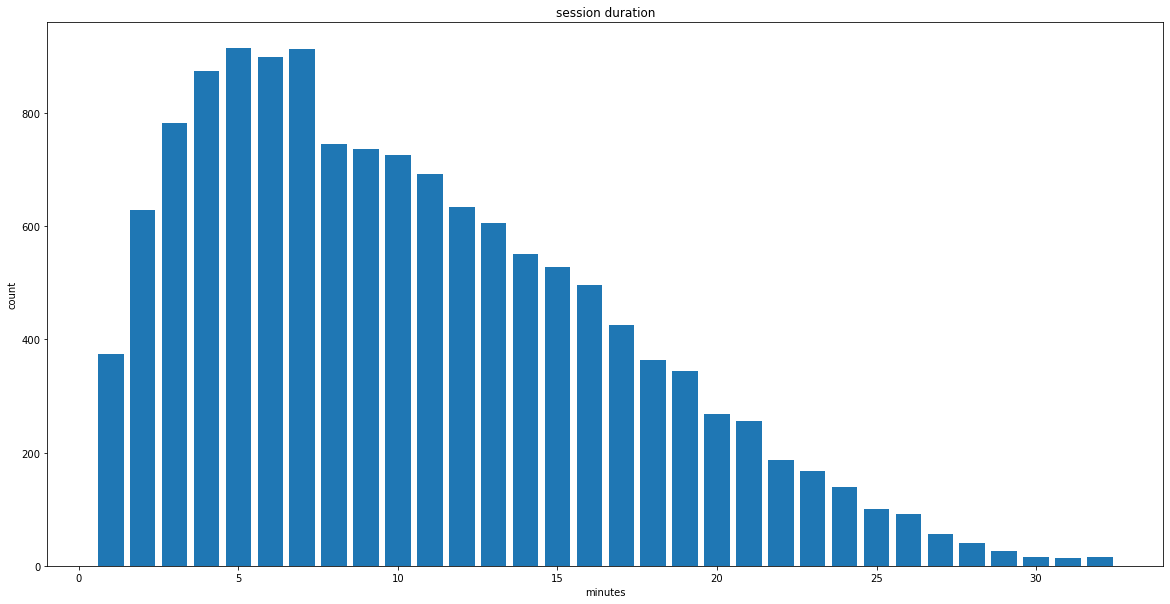

In [25]:
#dfdundee.Session_Duration

vc_duration = dfdundee.Session_Duration.value_counts()
vc_duration = vc_duration.sort_index()
x_duration = vc_duration.index
y_duration = vc_duration.values

plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_duration, y_duration)

plt.xlabel("minutes")
plt.ylabel("count")
plt.title("session duration")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/dundee_session_duration.png')
plt.show()


In [26]:
list(dfdundee)

['_id',
 'Charging event',
 'CP ID',
 'Connector',
 'Start Date',
 'Start Time',
 'End Date',
 'End Time',
 'Total kWh',
 'Cost',
 'Site',
 'Group',
 'Model',
 'Unnamed: 13',
 'Unnamed: 14',
 'Unnamed: 15',
 'Unnamed: 16',
 'Start_Timestamp',
 'End_Timestamp',
 'Session_Duration',
 'Minute_Load',
 'z_score',
 'Energy__Wh_',
 'plugin_time']

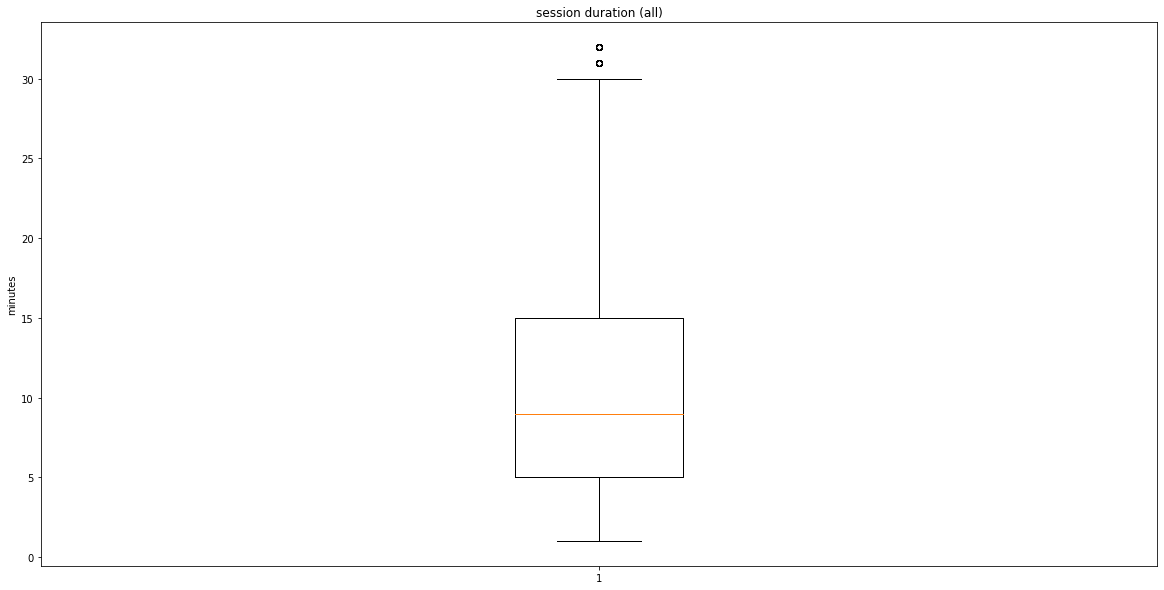

In [27]:
min(dfdundee.Session_Duration)
dfdundee.Start_Timestamp


plt.boxplot(dfdundee['Session_Duration'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (all)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/dundee_box_all.png')
plt.show()

In [28]:
def get_weekend(ts):
    if ts.weekday() > 4:
        return 1
    return 0

dfdundee['weekend'] = dfdundee['Start_Timestamp'].apply(get_weekend)

df_weekday = dfdundee[dfdundee['weekend'] == 0]
df_weekend = dfdundee[dfdundee['weekend'] == 1]

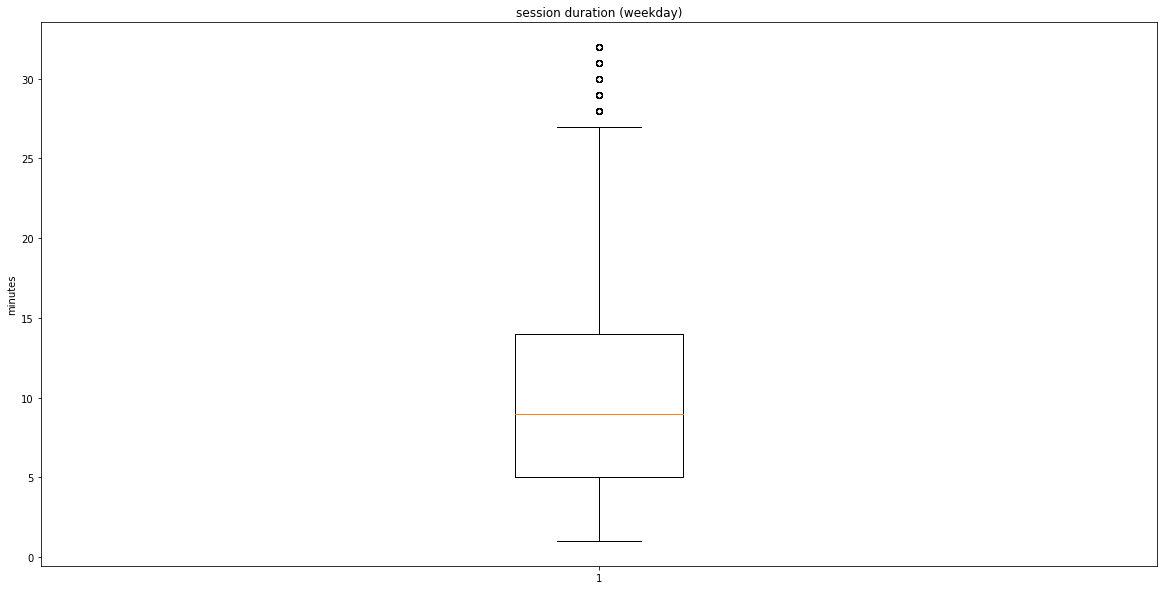

In [29]:
plt.boxplot(df_weekday['Session_Duration'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (weekday)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/dundee_box_weekday.png')
plt.show()

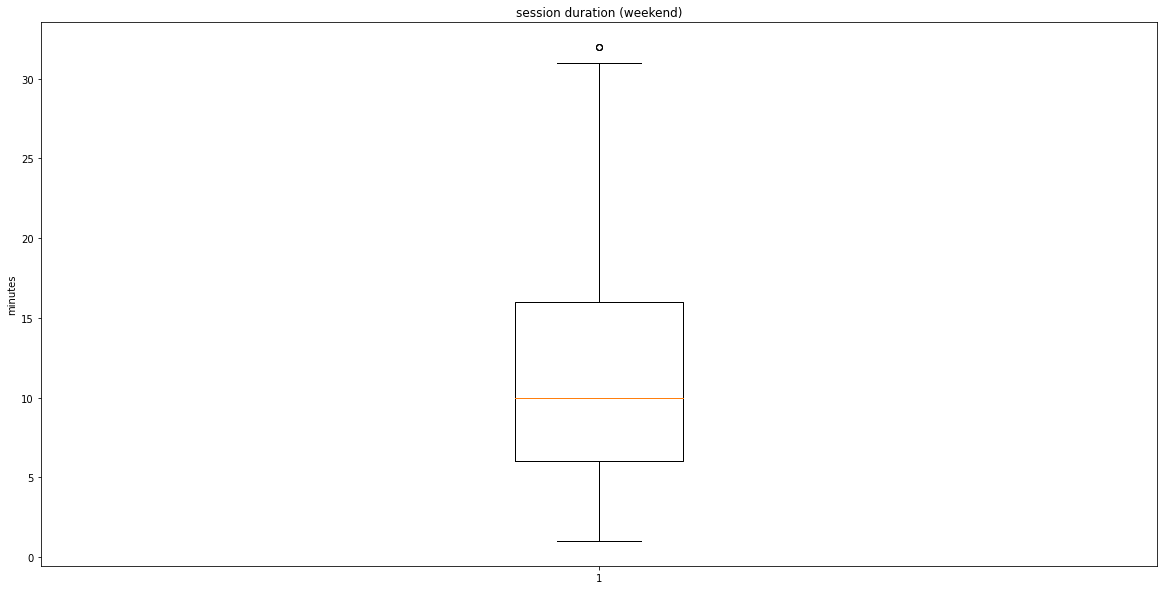

In [30]:
plt.boxplot(df_weekend['Session_Duration'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (weekend)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/dundee_box_end.png')
plt.show()

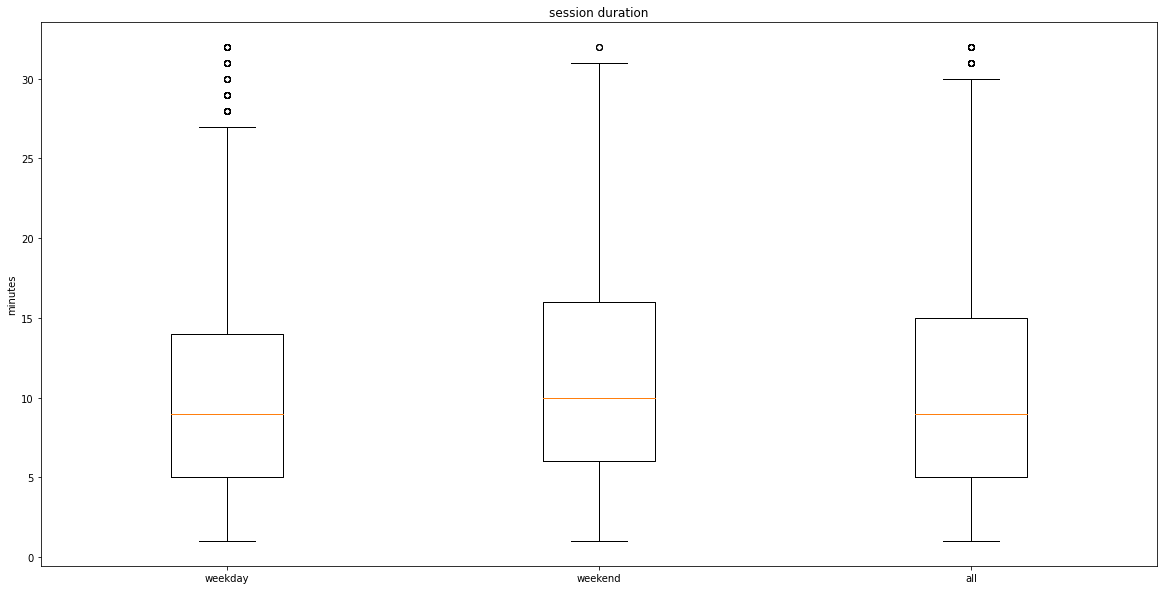

In [33]:
value_dict = {'weekday': df_weekday['Session_Duration'], 'weekend': df_weekend['Session_Duration'], 'all': dfdundee['Session_Duration']}

fig, ax = plt.subplots()
ax.boxplot(value_dict.values())
ax.set_xticklabels(value_dict.keys())
plt.rcParams["figure.figsize"] = (20,10)
plt.ylabel("minutes")
plt.title("session duration") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/dundee_boxes.png')
plt.show()